In [2]:
import numpy as np 
import pandas as pd 

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
# nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

In [3]:
spam_folder = 'C:/Users/pmh1407/Downloads/archive/spam'
ham_folder = 'C:/Users/pmh1407/Downloads/archive/ham'

ham_filenames = [name for name in sorted(os.listdir(ham_folder)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(spam_folder)) if len(name) > 20]

print('Number of non-spam samples:', len(ham_filenames))
print('Number of spam samples:', len(spam_filenames))
print('Ratio of non-spam to spam samples:', len(ham_filenames)/len(spam_filenames))

Number of non-spam samples: 2551
Number of spam samples: 501
Ratio of non-spam to spam samples: 5.091816367265469


In [4]:
import email.policy

def load_email(is_spam, filename):
    directory = spam_folder if is_spam else ham_folder
    
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]
ham_emails[1:3]
spam_emails[1:3]

In [5]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures


ham_structure = structures_counter(ham_emails)
spam_structure = structures_counter(spam_emails)
print(spam_structure)

Counter({'text/plain': 222, 'text/html': 181, 'multipart(text/plain, text/html)': 45, 'multipart(text/html)': 19, 'multipart(text/plain)': 19, 'multipart(multipart(text/html))': 5, 'multipart(text/plain, image/jpeg)': 3, 'multipart(text/html, application/octet-stream)': 2, 'multipart(text/plain, application/octet-stream)': 1, 'multipart(text/html, text/plain)': 1, 'multipart(multipart(text/html), application/octet-stream, image/jpeg)': 1, 'multipart(multipart(text/plain, text/html), image/gif)': 1, 'multipart/alternative': 1})


In [6]:
def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"

In [7]:
def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)
        
#print(email_to_plain(ham_emails[42]))
print(email_to_plain(spam_emails[45]))

Dear Sir or Madam:

Please reply to 
Receiver: China Enterprise Management Co., Ltd. (CMC)
E-mail: unido@chinatop.net

As one technical organization supported by China Investment and Technical Promotion Office of United Nation Industry Development Organization (UNIDO), we cooperate closely with the relevant Chinese Quality Supervision and Standardization Information Organization. We provide the most valuable consulting services to help you to open Chinese market within the shortest time:

1. Consulting Service on Mandatory National Standards of The People's Republic of China.

2. Consulting Service on Inspection and Quarantine Standards of The People's Republic of China.

3. Consulting Service for Permission to Enter Chinese Market

We are very sorry to disturb you! 

More information, please check our World Wide Web: http://www.chinatop.net

Sincerely yours

-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List mai

In [8]:
# structure all emails into plain text
ham_emails_plain = [email_to_plain(email) for email in ham_emails if len(ham_emails) > 10]
spam_emails_plain = [email_to_plain(email) for email in spam_emails if len(spam_emails) > 10]

In [9]:
# some data conversion to get it into pandas
ham_dic = {}
spam_dic = {}
ham_dic['text'] = ham_emails_plain
spam_dic['text'] = spam_emails_plain

ham_df = pd.DataFrame(ham_dic, columns = ['text', 'category'])
spam_df = pd.DataFrame(spam_dic, columns = ['text', 'category'])

# setting labels
ham_df['category'] = 0
spam_df['category'] = 1

frames = [ham_df, spam_df]

# dataframe of messages with proper labels for spam and non-spam
messages = pd.concat(frames).reset_index(drop=True)

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

sm = SnowballStemmer("english")

messages['text'] = messages['text'].astype(str).map(lambda text: re.sub('[^a-zA-Z0-9]+', ' ',text)).apply(lambda x: (x.lower()).split())
messages['text']= messages['text'].apply(lambda text_list:' '.join(list(map(lambda word:sm.stem(word),(list(filter(lambda text:text not in set(stopwords.words('english')),text_list)))))))

In [11]:
messages.head(4)

,text,category
0,date wed 21 aug 2002 10 54 46 0500 chris garri...,0
1,martin post tasso papadopoulo greek sculptor b...,0
2,man threaten explos moscow thursday august 22 ...,0
3,klez virus die alreadi prolif virus ever klez ...,0


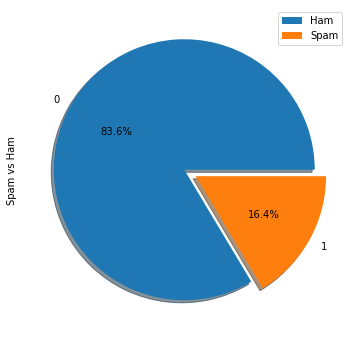

In [12]:
# Dropping rows with NA values
messages.dropna(inplace=True)

messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [13]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count      3052.000000
mean        879.644168
std        3036.337334
min           4.000000
25%         232.750000
50%         482.000000
75%         857.250000
max      123529.000000
Name: messageLength, dtype: float64

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", ngram_range=(1, 2), stop_words = "english")
features = vec.fit_transform(messages["text"])
print(features.shape)

(3052, 220383)


In [17]:
# from sklearn.model_selection import train_test_split
# print(features.shape)
# print(messages["category"].shape)
# X_train, X_test, y_train, y_test = train_test_split(features, messages["category"], stratify = messages["category"], test_size = 0.2, random_state=40)

(3052, 220383)
(3052,)


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

names = ["K Nearest Neighbors","Decision Tree", "Random Forest","Naive Bayes", "SVM"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    kf = KFold(random_state=40, n_splits=3,shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=kf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\n" + name + ":")
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_test, y_pred)))
    print("Confusion Matrix:\n") 
    confusion_m = confusion_matrix(y_test, y_pred)
    print(confusion_m)


K Nearest Neighbors:
Accuracy: 98.85%
Precision: 94.29%
Recall: 99.00%
F1 Score: 96.59%
Confusion Matrix:

[[505   6]
 [  1  99]]

Decision Tree:
Accuracy: 95.25%
Precision: 86.60%
Recall: 84.00%
F1 Score: 85.28%
Confusion Matrix:

[[498  13]
 [ 16  84]]

Random Forest:
Accuracy: 96.89%
Precision: 98.80%
Recall: 82.00%
F1 Score: 89.62%
Confusion Matrix:

[[510   1]
 [ 18  82]]

Naive Bayes:
Accuracy: 91.33%
Precision: 100.00%
Recall: 47.00%
F1 Score: 63.95%
Confusion Matrix:

[[511   0]
 [ 53  47]]

SVM:
Accuracy: 98.69%
Precision: 100.00%
Recall: 92.00%
F1 Score: 95.83%
Confusion Matrix:

[[511   0]
 [  8  92]]
